In [1]:
import numpy as np
import sklearn
from sklearn import model_selection
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from torch.autograd import Variable

torch.set_default_dtype(torch.float32)

def load_data(data_name):
    with np.load(data_name) as fh:
        data_x = fh['data_x']
        data_y = fh['data_y']
    return data_x, data_y

## Define VAE Model

In [2]:
## Model definition
## Encoder


class Encoder(torch.nn.Module):
    """Documentation for Encoder

    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.e1 = torch.nn.Linear(input_dim, hidden_dim)
        self.e2 = torch.nn.Linear(hidden_dim, 2*hidden_dim)
        self.e3 = torch.nn.Linear(2*hidden_dim, latent_dim)
        self.e4 = torch.nn.Linear(2*hidden_dim, latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.e1(x))
        x = F.leaky_relu(self.e2(x))
        mean = self.e3(x)
        log_variance = self.e4(x)
        return mean, log_variance


## Decoder


class Decoder(torch.nn.Module):
    """Documentation for Decoder

    """
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.d1 = torch.nn.Linear(latent_dim, 2*hidden_dim)
        self.d2 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.d3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.d1(x))
        x = F.leaky_relu(self.d2(x))
        output = torch.sigmoid(self.d3(x))        
        return output


## VAE


class VAE(torch.nn.Module):
    """Documentation for VAE

    """
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, log_variance):
        variance = torch.exp(.5 * log_variance)
        epsilon = torch.randn_like(variance).to(DEVICE)
        z = mean + variance * epsilon
        return z

    def forward(self, x):
        mean, log_variance = self.Encoder(x)
        z = self.reparameterization(mean, log_variance)
        output = self.Decoder(z)
        return output, mean, log_variance


## Loss function

def loss_func(output, x, mean, log_variance):
    loss_reproduction = F.binary_cross_entropy(output, x, reduction='sum')
    kld = -.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    return loss_reproduction + kld


## Define Model CVAE

In [3]:
## Model definition
## Encoder
class CEncoder(torch.nn.Module):
    """Documentation for Encoder

    """
    def __init__(self, input_dim, hidden_dim, latent_dim, cond_dim):
        super(CEncoder, self).__init__()
        self.e1 = torch.nn.Linear(input_dim + cond_dim, hidden_dim)
        self.e2 = torch.nn.Linear(hidden_dim, 2*hidden_dim)
        self.e3 = torch.nn.Linear(2*hidden_dim, latent_dim)
        self.e4 = torch.nn.Linear(2*hidden_dim, latent_dim)

    def forward(self, x, c):
        concat_input = torch.cat([x, c], 1)
        x = F.leaky_relu(self.e1(concat_input))
        x = F.leaky_relu(self.e2(x))
        mean = self.e3(x)
        log_variance = self.e4(x)
        return mean, log_variance


## Decoder


class CDecoder(torch.nn.Module):
    """Documentation for Decoder

    """
    def __init__(self, latent_dim, hidden_dim, output_dim, cond_dim):
        super(CDecoder, self).__init__()
        self.d1 = torch.nn.Linear(latent_dim + cond_dim, 2*hidden_dim)
        self.d2 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.d3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, c):
        concat_input = torch.cat([x, c], 1)
        x = F.leaky_relu(self.d1(concat_input))
        x = F.leaky_relu(self.d2(x))
        output = torch.sigmoid(self.d3(x))        
        return output


## VAE


class CVAE(torch.nn.Module):
    """Documentation for VAE

    """
    def __init__(self, Encoder, Decoder):
        super(CVAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, log_variance):
        variance = torch.exp(.5 * log_variance)
        epsilon = torch.randn_like(variance).to(DEVICE)
        z = mean + variance * epsilon
        return z

    def forward(self, x, c):
        mean, log_variance = self.Encoder(x, c)
        z = self.reparameterization(mean, log_variance)
        output = self.Decoder(z, c)
        return output, mean, log_variance

## one-hot encoding
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

## Hyper parameter initialization

In [4]:
data_name = 'vae-cvae-challenge.npz'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_dim = 784
batch_size = 1024
hidden_dim = 256
latent_dim = 2
epochs = 300
lr = .001
# load the data
data_x, data_y = load_data(data_name)
print(data_x.shape, data_y.shape)

(20000, 784) (20000,)


## Split train and test data

In [5]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_x, data_y, test_size=.2)
data_train = torch.from_numpy(x_train)
label_train = torch.from_numpy(y_train)
data_test = torch.from_numpy(x_test)
label_test = torch.from_numpy(y_test)
dataset_test = TensorDataset(data_test, label_test)

dataset_train = TensorDataset(data_train, label_train)   
dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Build and train VAE model

In [6]:
encoder = Encoder(x_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, x_dim)
vae = VAE(encoder, decoder)
vae = vae.to(DEVICE)
optimizer = Adam(vae.parameters(), lr=lr)
vae

VAE(
  (Encoder): Encoder(
    (e1): Linear(in_features=784, out_features=256, bias=True)
    (e2): Linear(in_features=256, out_features=512, bias=True)
    (e3): Linear(in_features=512, out_features=2, bias=True)
    (e4): Linear(in_features=512, out_features=2, bias=True)
  )
  (Decoder): Decoder(
    (d1): Linear(in_features=2, out_features=512, bias=True)
    (d2): Linear(in_features=512, out_features=256, bias=True)
    (d3): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [7]:
loss_list = []
for epoch in tqdm(range(epochs)):
    losses = 0
    # unsupervised.
    for idx, (x, _) in enumerate(dl_train):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        output, mean, log_variance = vae(x)
        loss = loss_func(output, x, mean, log_variance)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        if x.shape[0] < batch_size:
            loss_list += [loss.item() / x.shape[0]]
        else:
            loss_list += [loss.item() / batch_size]
    #print(f' training loss -- {losses / (idx * batch_size)}') 

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:19<00:00,  3.77it/s]


## Save model

In [8]:
torch.save(vae.state_dict(), "vae_model")

## Visualize loss

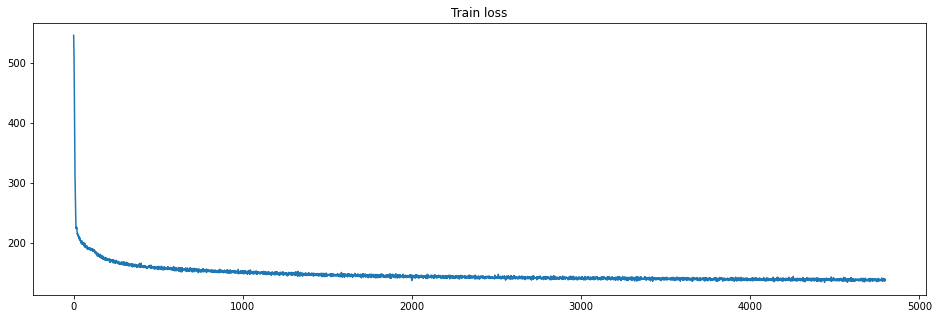

In [9]:
import matplotlib.pyplot as plt
# visualize losses
f, ax = plt.subplots(figsize=(16, 5))
ax.plot(loss_list)
ax.title.set_text("Train loss")

## Load VAE model

In [10]:
vae = VAE(Encoder(x_dim, hidden_dim, latent_dim),Decoder(latent_dim, hidden_dim, x_dim))
vae.load_state_dict(torch.load("vae_model"))
vae = vae.to(DEVICE)

## Plot the latent space

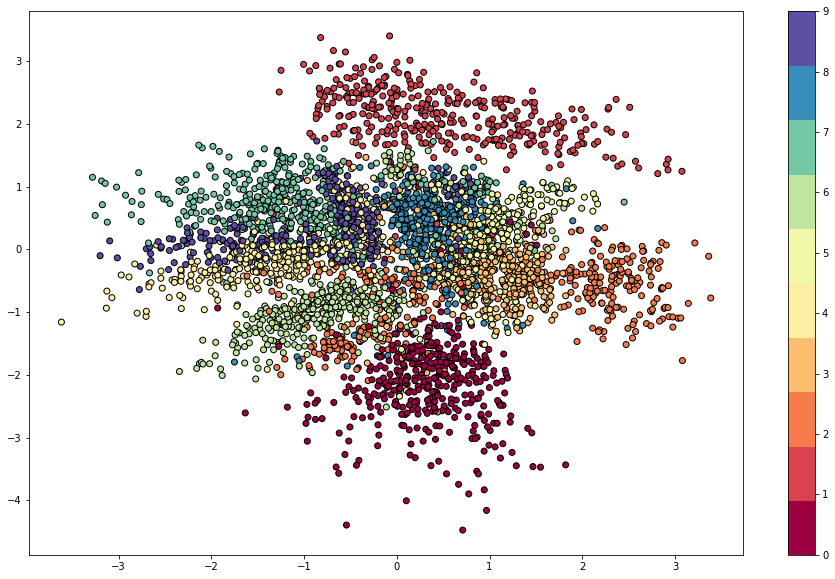

In [11]:
fig, axe = plt.subplots(figsize=(16, 10))
data_test = data_test.to(DEVICE)
mu, log_variance = vae.Encoder(data_test)
z = vae.reparameterization(mu, log_variance)
z_x = z.cpu().detach().numpy()[:, 0]
z_y = z.cpu().detach().numpy()[:, 1]
labels = label_test.detach().numpy()
plt.scatter(z_x, z_y, c=labels, cmap=plt.cm.get_cmap('Spectral', 10), alpha=1, edgecolors='black')
plt.colorbar()

## Reconstruction the image according only to the latent space position np.arange(-5, 5, .2) for both x and y

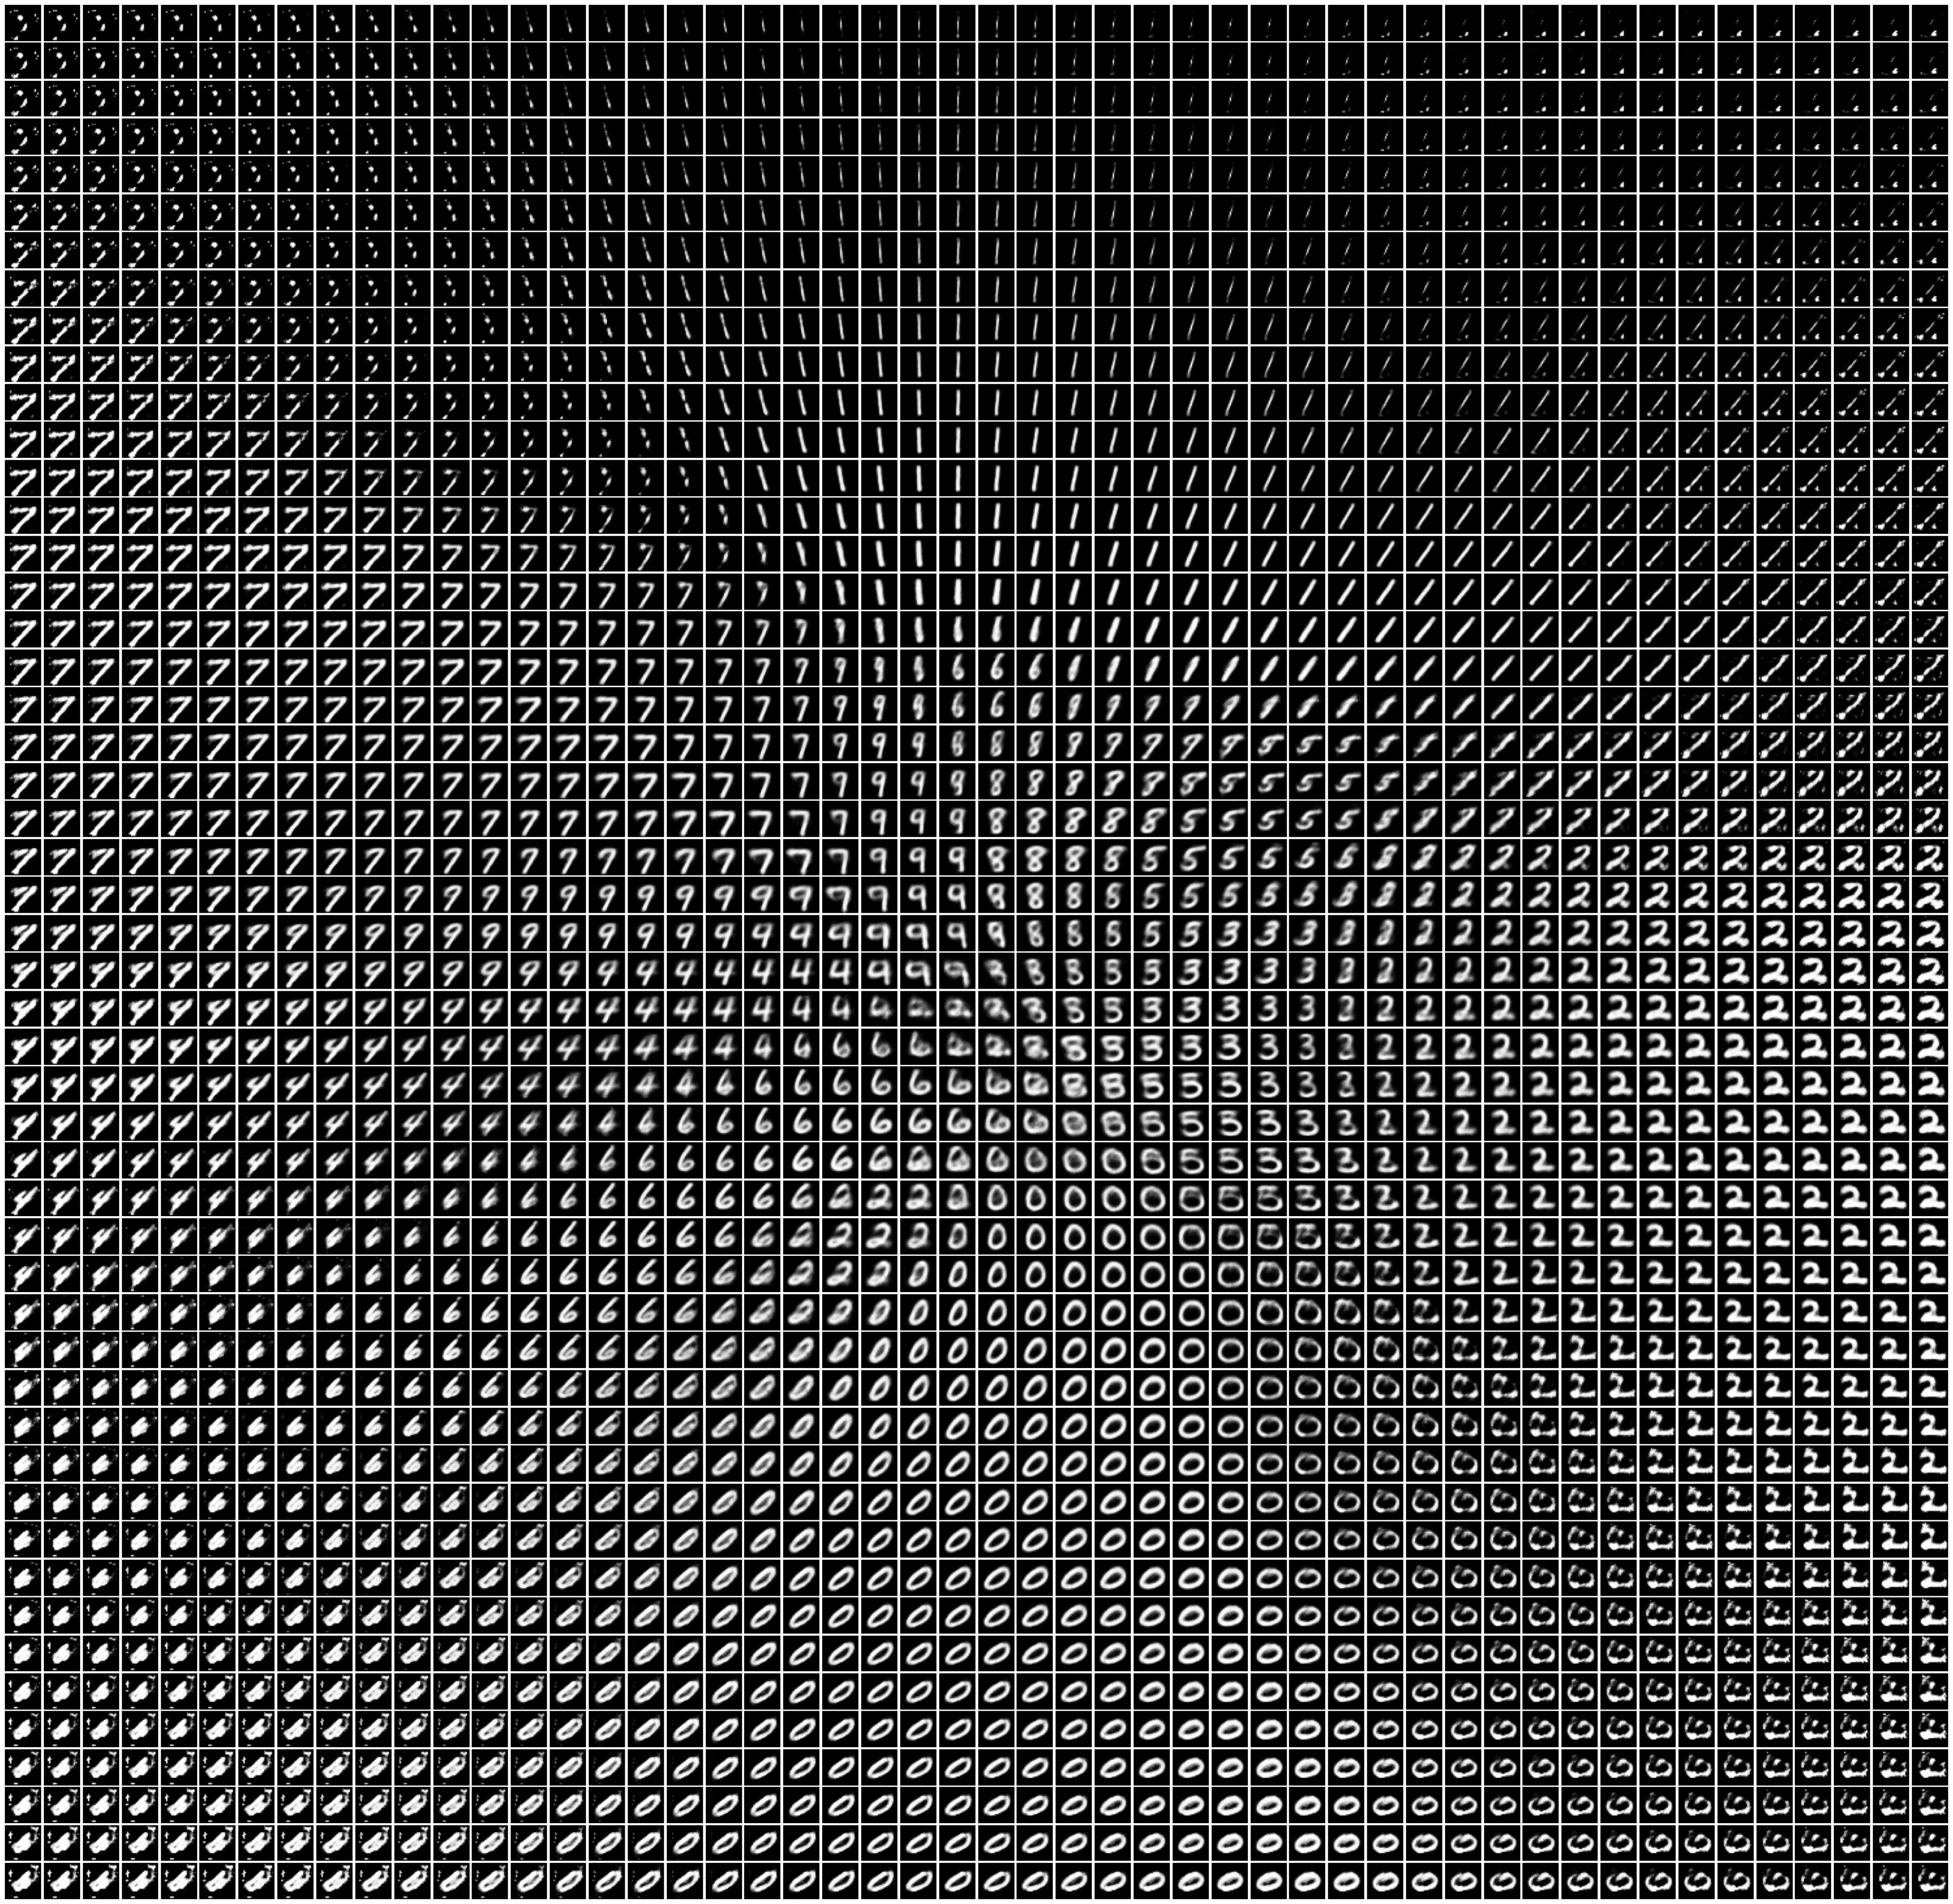

In [12]:
xmin, xmax, ymin, ymax = -5, 5, -5, 5
step = .2
rows = len(np.arange(xmin, xmax, step))
cols = len(np.arange(ymin, ymax, step))
fig_pos_grid = plt.figure(figsize=(rows, cols))
gs_pos_grid = gridspec.GridSpec(rows, cols)
gs_pos_grid.update(wspace=0.05, hspace=0.05)
#loop over the grid [-5, 5] in 2 D
z_list = []
for j, y_step in enumerate(np.arange(ymin, ymax, step)[::-1]):
    for i, x_step in enumerate(np.arange(xmin, xmax, step)):
        #import ipdb; ipdb.set_trace()
        ax = plt.subplot(gs_pos_grid[j*cols+i])
        plt.axis('off')
        ax.set_aspect('equal')
        _z = torch.Tensor([[x_step, y_step]]).to(DEVICE)
        z_list.append(_z)
        # reconstruct the image
        img_rec = vae.Decoder(_z)
        plt.imshow(img_rec.cpu().detach().reshape(28, 28), cmap='Greys_r')

## reconstruct MNIST image using test data

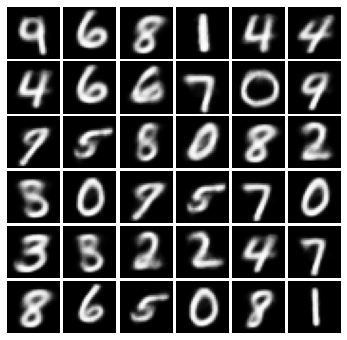

In [13]:
samples, _, _ = vae(data_test)
grid_x = 6
sample_size = grid_x**2
ids = np.random.randint(0, samples.shape[0], sample_size)
samples = samples[ids].cpu().detach().numpy()
fig_dec = plt.figure(figsize=(grid_x, grid_x))
gs = gridspec.GridSpec(grid_x, grid_x)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

## Compare with the original test image

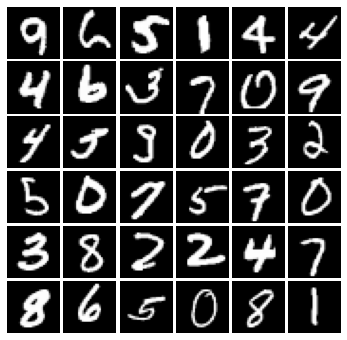

In [14]:
samples = data_test
grid_x = 6
sample_size = grid_x**2
samples = samples[ids].cpu().detach().numpy()
fig_dec = plt.figure(figsize=(grid_x, grid_x))
gs = gridspec.GridSpec(grid_x, grid_x)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

##################################################################################
# Build and train CVAE model

### Condition dimension for the model

In [15]:
cond_dim = label_train.unique().size(0)

In [16]:
c_encoder = CEncoder(x_dim, hidden_dim, latent_dim-1, cond_dim)
c_decoder = CDecoder(latent_dim-1, hidden_dim, x_dim, cond_dim)
cvae = CVAE(c_encoder, c_decoder)
cvae = cvae.to(DEVICE)
optimizer = Adam(cvae.parameters(), lr=lr)

In [17]:
loss_list = []
for epoch in tqdm(range(epochs)):
    losses = 0
    # unsupervised.
    for idx, (x, cond) in enumerate(dl_train):
        x, cond = x.to(DEVICE), one_hot(cond, cond_dim).to(DEVICE)
        optimizer.zero_grad()
        output, mean, log_variance = cvae(x, cond)
        loss = loss_func(output, x, mean, log_variance)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        if x.shape[0] < batch_size:
            loss_list += [loss.item() / x.shape[0]]
        else:
            loss_list += [loss.item() / batch_size]
    #print(f' training loss -- {losses / (idx * batch_size)}') 

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:53<00:00,  2.65it/s]


## Plot the loss

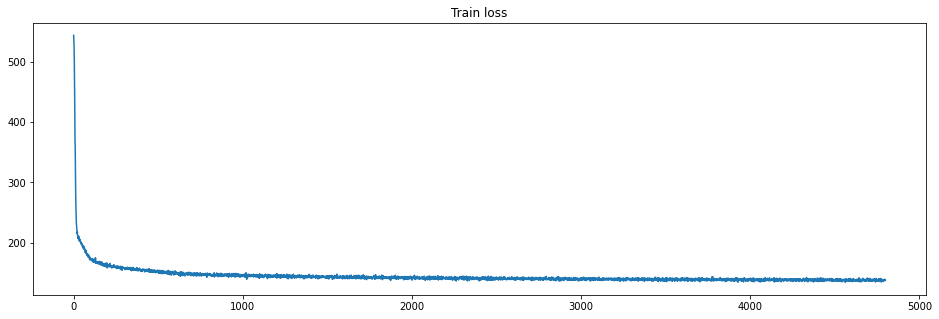

In [18]:
import matplotlib.pyplot as plt
# visualize losses
f, ax = plt.subplots(figsize=(16, 5))
ax.plot(loss_list)
ax.title.set_text("Train loss")

## Save the CVAE model

In [19]:
torch.save(cvae.state_dict(), "cvae_model")

## Load CVAE model

In [20]:
cvae = CVAE(CEncoder(x_dim, hidden_dim, latent_dim-1, cond_dim),CDecoder(latent_dim-1, hidden_dim, x_dim, cond_dim))
cvae.load_state_dict(torch.load("cvae_model"))
cvae = cvae.to(DEVICE)

## Plot the latent space

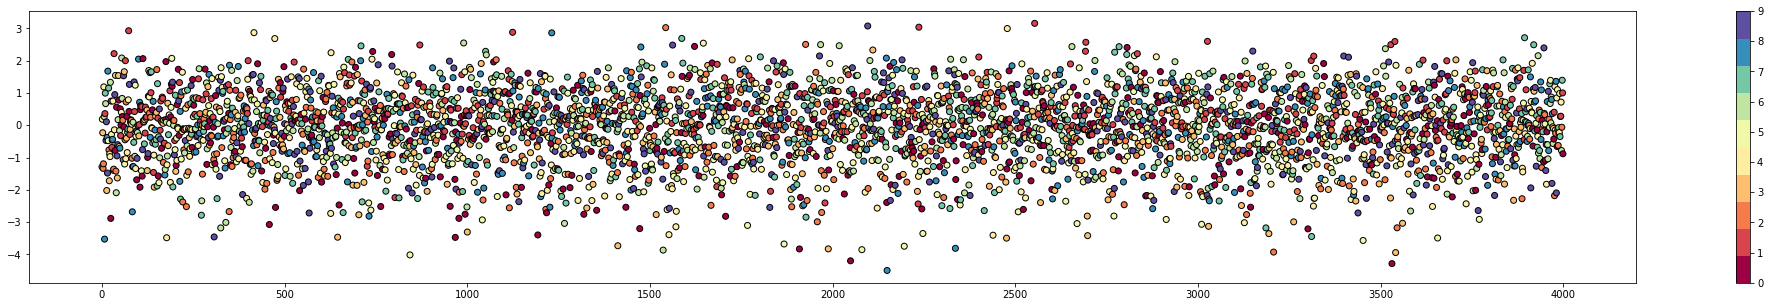

In [21]:
fig, axe = plt.subplots(figsize=(36, 5))
data_test = data_test.to(DEVICE)
cond_test = one_hot(label_test, cond_dim).to(DEVICE)
mu, log_variance = cvae.Encoder(data_test, cond_test)
z = cvae.reparameterization(mu, log_variance)
z_x = z.cpu().detach().numpy()
z_y = range(z.size(0))
labels = label_test.cpu().detach().numpy()
plt.scatter(z_y, z_x, c=labels, cmap=plt.cm.get_cmap('Spectral', 10), alpha=1, edgecolors='black')
plt.colorbar()

## Reconstruct the image using latent space postion np.arange[-5, 5, .2] and a label condition

<Figure size 72x360 with 0 Axes>

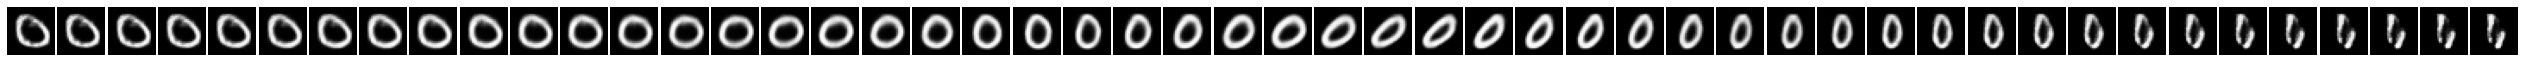

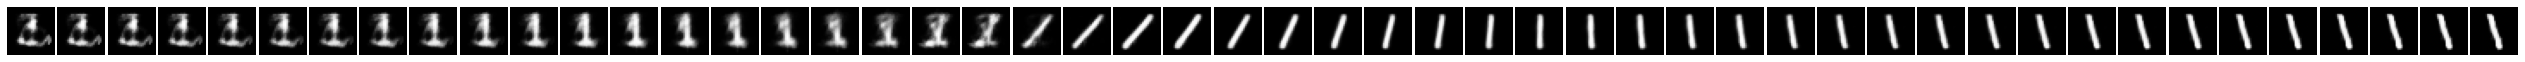

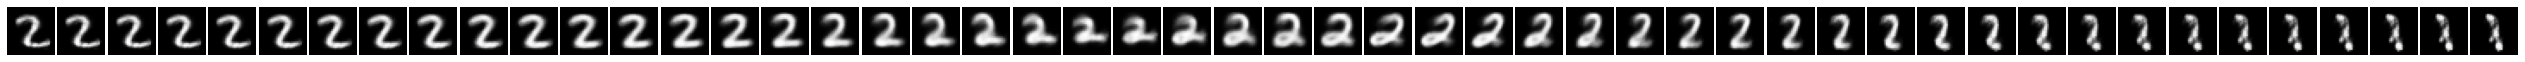

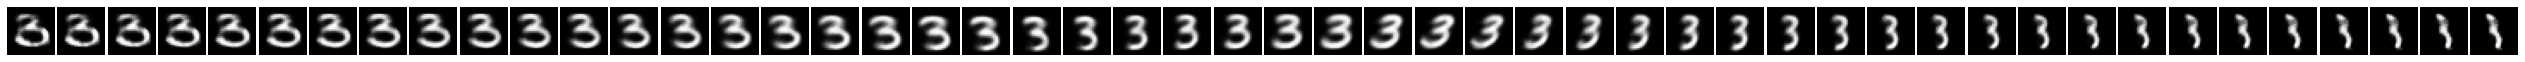

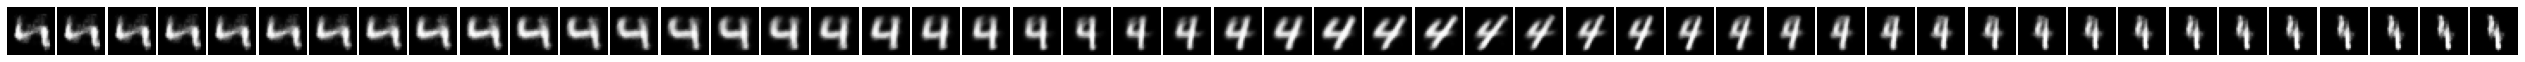

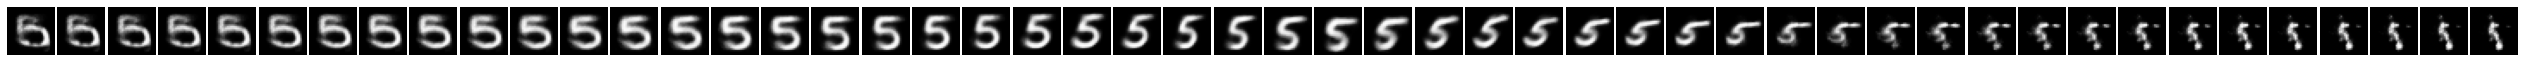

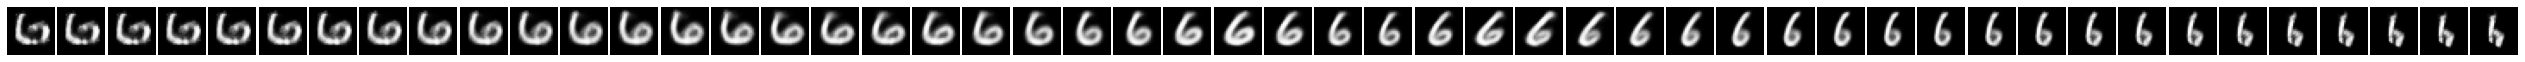

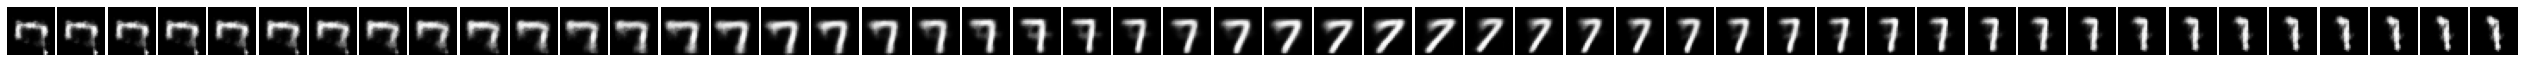

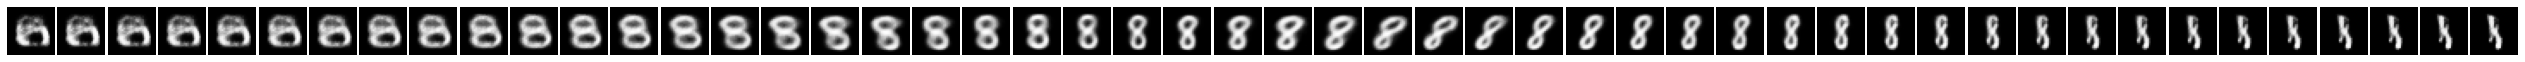

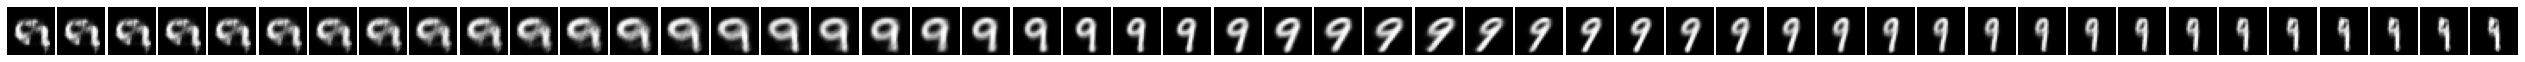

In [22]:
xmin, xmax, = -5, 5
step = .2
cols = len(np.arange(xmin, xmax, step))
rows = 1
fig_pos_grid = plt.figure(figsize=(rows, 5))
gs_pos_grid = gridspec.GridSpec(rows, cols)
gs_pos_grid.update(wspace=0.05, hspace=0.05)
labels = torch.from_numpy(np.array(range(0,10)))
_cond = one_hot(labels, 10).to(DEVICE)
#loop over the grid [-5, 5] in 1 D
for l, label in enumerate(range(0, 10)):
    fig_pos_grid = plt.figure(figsize=(45, cols))
    gs_pos_grid = gridspec.GridSpec(rows, cols)
    gs_pos_grid.update(wspace=0.05, hspace=0.05)
    _label = torch.from_numpy(np.array([label]))
    _cond = one_hot(_label, 10).to(DEVICE)
    for i, x_step in enumerate(np.arange(xmin, xmax, step)):
        ax = plt.subplot(gs_pos_grid[i])
        plt.axis('off')
        ax.set_aspect('equal')
        _z = torch.Tensor([[x_step]]).to(DEVICE)
        # reconstruct the image
        img_rec = cvae.Decoder(_z, _cond)
        plt.imshow(img_rec.cpu().detach().reshape(28, 28), cmap='Greys_r')

## plot the reconstructed MNIST image

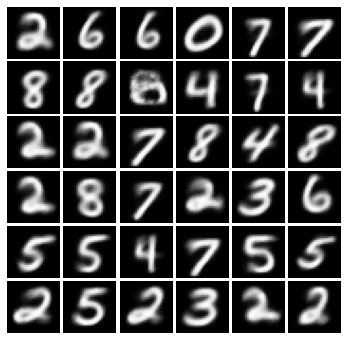

In [23]:
samples, _, _ = cvae(data_test, cond_test)
grid_x = 6
sample_size = grid_x**2
ids = np.random.randint(0, samples.shape[0], sample_size)
samples = samples[ids].cpu().detach().numpy()
fig_dec = plt.figure(figsize=(grid_x, grid_x))
gs = gridspec.GridSpec(grid_x, grid_x)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

In [24]:
label_test[ids]

tensor([2, 6, 6, 0, 7, 7, 8, 8, 8, 4, 7, 4, 2, 2, 7, 8, 4, 8, 2, 8, 7, 2, 3, 6,
        5, 5, 4, 7, 5, 5, 2, 5, 2, 3, 2, 2])

## Now Let's change our conditions, inverse all the labels conditions

In [25]:
cond_test_flipped = torch.flip(cond_test, (0,))
label_test_flipped = torch.flip(label_test, (0,))
label_test_flipped[ids]

tensor([0, 3, 2, 5, 0, 2, 1, 6, 3, 6, 2, 1, 9, 2, 4, 8, 8, 1, 0, 1, 8, 6, 2, 9,
        4, 8, 4, 4, 5, 7, 6, 9, 9, 2, 5, 9])

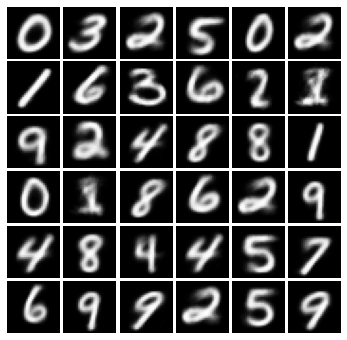

In [26]:
samples, _, _ = cvae(data_test, cond_test_flipped)
grid_x = 6
sample_size = grid_x**2
samples = samples[ids].cpu().detach().numpy()
fig_dec = plt.figure(figsize=(grid_x, grid_x))
gs = gridspec.GridSpec(grid_x, grid_x)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

### Comparing the results of the latent space from both VAE and CVAE, we can see the VAE can cleerly speparate the labels in latent space, whereas the CVAE can not sperate purely according to its locations on 1D, but we can see that we can give any class numbers (add the condition) to let the CVAE network generate the corresponding hand writing numbers.